**MSc in Big Data & Analytics Kosmas Katsioulas | ME2109 | Part A - EDA**

# **Libraries & Packages**

In [1]:
!pip uninstall -y torch torchvision torchaudio
!pip install --index-url https://download.pytorch.org/whl/cpu torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1
!pip install ultralytics==8.3.180 motmetrics==1.4.0 deep_sort_realtime==1.3.2 seaborn==0.13.2 opencv-python-headless==4.10.0.84 pandas==2.2.2 matplotlib==3.8.4 pyyaml==6.0.2 tqdm==4.67.1

Found existing installation: torch 2.4.1+cpu
Uninstalling torch-2.4.1+cpu:
  Successfully uninstalled torch-2.4.1+cpu
Found existing installation: torchvision 0.19.1+cpu
Uninstalling torchvision-0.19.1+cpu:
  Successfully uninstalled torchvision-0.19.1+cpu
Found existing installation: torchaudio 2.4.1+cpu
Uninstalling torchaudio-2.4.1+cpu:
  Successfully uninstalled torchaudio-2.4.1+cpu
Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached https://download.pytorch.org/whl/cpu/torch-2.4.1%2Bcpu-cp312-cp312-linux_x86_64.whl (194.8 MB)
  Using cached https://download.pytorch.org/whl/cpu/torchvision-0.19.1%2Bcpu-cp312-cp312-linux_x86_64.whl (1.6 MB)
  Using cached https://download.pytorch.org/whl/cpu/torchaudio-2.4.1%2Bcpu-cp312-cp312-linux_x86_64.whl (1.7 MB)


In [2]:
import os, glob, re, json, time, math, random, shutil
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from zipfile import ZipFile
from collections import defaultdict
from tqdm import tqdm
from collections import Counter

In [3]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

In [4]:
sns.set(style="whitegrid", font_scale=1.0)
plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams["savefig.dpi"] = 150

# **Mount Google Drive**

In [5]:
IN_COLAB = False
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except Exception:
    pass

Mounted at /content/drive


# **Useful Paths**

In [6]:
zip_path = '/content/drive/MyDrive/Diploma/UNIRI_HBD_Dataset/uniri-hbd.zip'
extract_root = '/content/uniri-hbd'

In [7]:
if os.path.exists(zip_path) and not os.path.exists(extract_root):
    with ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_root)
    print("Extracted:", extract_root)
else:
    print("Zip not found or already extracted).")

Extracted: /content/uniri-hbd


In [8]:
base_dir = os.path.join(extract_root, "handball_s")
scenes_dir = os.path.join(base_dir, "scenes")
detections_dir = os.path.join(base_dir, "player_detections")

In [9]:
results_dir = "/content/eda_results"
os.makedirs(results_dir, exist_ok=True)

# **Useful Functions**

**Robust Parser Function**

In [11]:
def parse_uniri_csv(csv_path: str) -> pd.DataFrame:

    rows, current_frame = [], None

    with open(csv_path, "r") as f:

        for raw in f:

            line = raw.strip()

            if not line:

                continue

            if line.lower().startswith("frame"):

                nums = re.findall(r"\d+", line)
                current_frame = int(nums[0]) if nums else None

                continue

            parts = re.split(r"[,\s]+", line.strip(", "))

            if current_frame is None or len(parts) < 5:

                continue

            try:

                x1, y1, x2, y2, conf = map(float, parts[:5])
                rows.append([current_frame, x1, y1, x2, y2, conf])

            except Exception:

                pass

    df = pd.DataFrame(rows, columns=["frame", "x1", "y1", "x2", "y2", "conf"])

    if not df.empty:

        df = df.sort_values(["frame"]).reset_index(drop=True)

    return df

In [12]:
def video_path_from_csv(csv_path: str) -> str:

    action = os.path.basename(os.path.dirname(csv_path))
    stem = os.path.splitext(os.path.basename(csv_path))[0]

    return os.path.join(scenes_dir, action, f"{stem}.mp4")

In [13]:
def overlay_boxes_on_image(image_bgr: np.ndarray, boxes_xyxy: np.ndarray, color=(0, 255, 0)) -> np.ndarray:

    out = image_bgr.copy()

    for (x1, y1, x2, y2) in boxes_xyxy.astype(int):

        cv2.rectangle(out, (x1, y1), (x2, y2), color, 2)

    return out

# **Dataset Structure**

In [14]:
actions = sorted([d for d in os.listdir(detections_dir) if os.path.isdir(os.path.join(detections_dir, d))])
print("Actions found:", actions)

Actions found: ['crossing', 'defence', 'dribbling', 'jump-shot', 'passing', 'running', 'shot']


In [15]:
rows = []
for a in actions:
    csvs = sorted(glob.glob(os.path.join(detections_dir, a, "*.csv")))
    vids = sorted(glob.glob(os.path.join(scenes_dir, a, "*.mp4")))
    rows.append({"action": a, "csv_count": len(csvs), "video_count": len(vids)})

In [16]:
df_inventory = pd.DataFrame(rows).sort_values("action").reset_index(drop=True)
display(df_inventory)

,action,csv_count,video_count
0,crossing,129,129
1,defence,16,16
2,dribbling,24,24
3,jump-shot,367,370
4,passing,104,104
5,running,9,9
6,shot,102,102


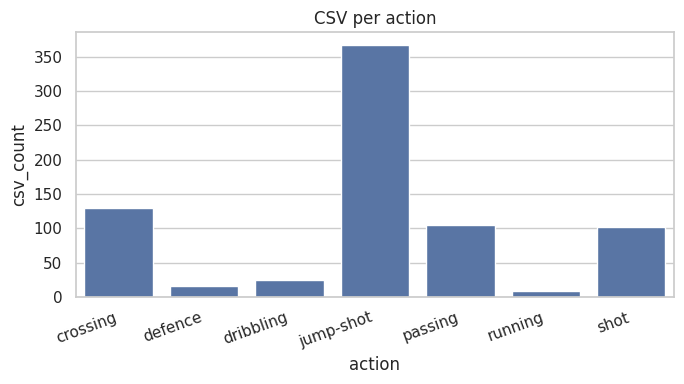

In [18]:
plt.figure(figsize=(7,4))
sns.barplot(df_inventory, x="action", y="csv_count")
plt.title("CSV per action")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "Bar_csv_per_Action_Kosmas_Katsioulas_ME2109.png"))
plt.show()

# **Sanity Check**

In [19]:
sample_csv = sorted(glob.glob(os.path.join(detections_dir, actions[0], "*.csv")))[0]
df_sample = parse_uniri_csv(sample_csv)
vid_path = video_path_from_csv(sample_csv)

In [20]:
cap = cv2.VideoCapture(vid_path)
ok, first_frame = cap.read()
cap.release()

In [21]:
fmin = int(df_sample.frame.min())
boxes = df_sample[df_sample.frame == fmin][["x1","y1","x2","y2"]].to_numpy()
overlay = overlay_boxes_on_image(first_frame, boxes)

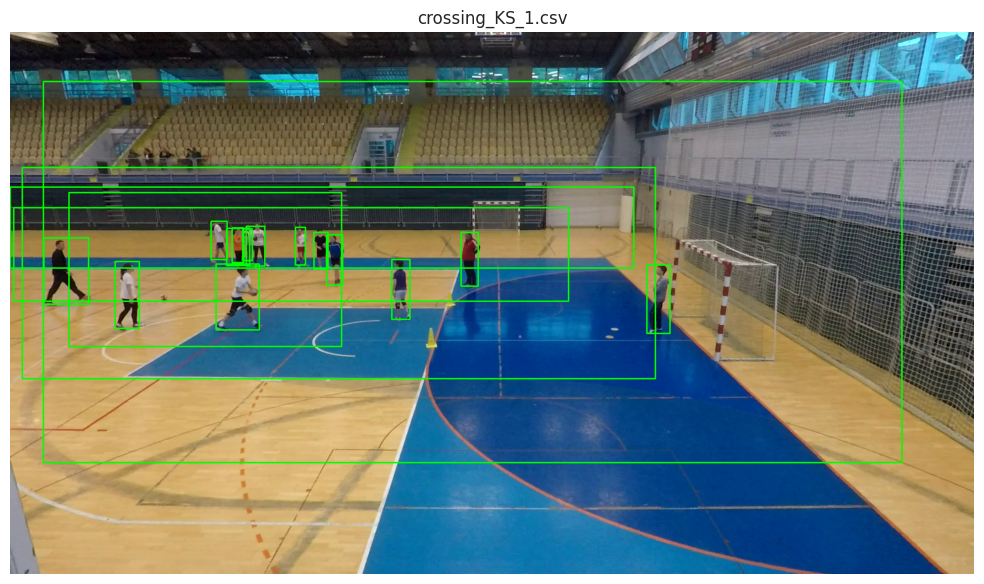

In [22]:
plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title(Path(sample_csv).name)
plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "Overlay_First_Frame_Kosmas_Katsioulas_ME2109.png"))
plt.show()

# **Video Features per Action**

In [23]:
video_rows = []
max_vids_per_action = 10

In [24]:
for a in actions:

    cand = sorted(glob.glob(os.path.join(scenes_dir, a, "*.mp4")))[:max_vids_per_action]

    for vp in cand:

        cap = cv2.VideoCapture(vp)

        if not cap.isOpened():

            video_rows.append({"action": a, "video": Path(vp).name, "width": None, "height": None, "fps": None, "frames": None})
            continue

        W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = float(cap.get(cv2.CAP_PROP_FPS) or 30.0)
        nF = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        video_rows.append({"action": a, "video": Path(vp).name, "width": W, "height": H, "fps": fps, "frames": nF})

In [25]:
df_video_info = pd.DataFrame(video_rows)
display(df_video_info.head(15))

,action,video,width,height,fps,frames
0,crossing,crossing_KS_1.mp4,1920,1080,47.952,82
1,crossing,crossing_KS_10.mp4,1920,1080,47.952,81
2,crossing,crossing_KS_100.mp4,1920,1080,47.952,67
3,crossing,crossing_KS_101.mp4,1920,1080,47.952,81
4,crossing,crossing_KS_102.mp4,1920,1080,47.952,82
5,crossing,crossing_KS_103.mp4,1920,1080,47.952,82
6,crossing,crossing_KS_104.mp4,1920,1080,47.952,66
7,crossing,crossing_KS_105.mp4,1920,1080,47.952,82
8,crossing,crossing_KS_106.mp4,1920,1080,47.952,83
9,crossing,crossing_KS_107.mp4,1920,1080,47.952,85


In [26]:
agg = df_video_info.groupby("action")[["width","height","fps","frames"]].agg(["mean","min","max","count"])
display(agg)

width                    height                        fps  \
             mean   min   max count    mean   min   max count     mean   
action                                                                   
crossing   1920.0  1920  1920    10  1080.0  1080  1080    10  47.9520   
defence    1920.0  1920  1920    10  1080.0  1080  1080    10  47.9520   
dribbling  1920.0  1920  1920    10  1080.0  1080  1080    10  47.9528   
jump-shot  1998.4  1920  2704    10  1124.0  1080  1520    10  47.9520   
passing    2625.6  1920  2704    10  1476.0  1080  1520    10  47.9520   
running    1920.0  1920  1920     9  1080.0  1080  1080     9  47.9520   
shot       2155.2  1920  2704    10  1212.0  1080  1520    10  47.9520   

                                     frames                 
              min     max count        mean min  max count  
action                                                      
crossing   47.952  47.952    10   79.100000  66   85    10  
defence    47.952  47.952    10   92.900000  81  130    10  
dribbling  47.952  47.954    10   89.600000  65  129    10  
jump-shot  47.952  47.952    10   75.300000  65  130    10  
passing    47.952  47.952    10   69.900000  65   81    10  
running    47.952  47.952     9  117.666667  82  146     9  
shot       47.952  47.952    10   78.100000  65   97    10

In [27]:
df_video_info.to_csv(os.path.join(results_dir, "Video_Inventory_Kosmas_Katsioulas_ME2109.csv"), index=False)
agg.to_csv(os.path.join(results_dir, "Video_Inventory_Aggregates_Kosmas_Katsioulas_ME2109.csv"))

# **Detections Per Frame Per Action**

In [28]:
def frame_density_stats(csv_list: list, sample: int = 10) -> dict:

    if sample is not None:

        csv_list = csv_list[:sample]

    all_counts = []

    for cp in csv_list:

        d = parse_uniri_csv(cp)

        if d.empty:

            continue

        counts = d.groupby("frame").size().values

        if len(counts):

            all_counts.extend(counts.tolist())

    if not all_counts:

        return {"mean":0.0,"p50":0.0,"p90":0.0,"max":0}

    arr = np.asarray(all_counts, dtype=float)

    return {"mean": float(arr.mean()),
            "p50": float(np.percentile(arr, 50)),
            "p90": float(np.percentile(arr, 90)),
            "max": int(arr.max())}

In [29]:
density_rows = []
for a in actions:
    csvs = sorted(glob.glob(os.path.join(detections_dir, a, "*.csv")))
    density_rows.append({"action": a, **frame_density_stats(csvs, sample=10)})

In [30]:
df_density = pd.DataFrame(density_rows).sort_values("action")
display(df_density)

,action,mean,p50,p90,max
0,crossing,13.494311,13.0,20.0,26
1,defence,11.287406,11.0,15.0,23
2,dribbling,20.198661,20.0,28.0,38
3,jump-shot,41.729084,42.0,48.0,62
4,passing,23.380544,23.0,33.0,45
5,running,30.032106,30.0,37.0,46
6,shot,23.338028,17.0,43.0,52


In [31]:
df_density.to_csv(os.path.join(results_dir, "Detections_per_Frame_stats_Kosmas_Katsioulas_ME2109.csv"), index=False)

# **Confidence & Sizes**

In [32]:
def sample_confidence_and_sizes(csv_paths: list, max_csvs: int = 20, cap_rows_per_csv: int = 20000):

    conf_vals, sizes = [], []
    csv_paths = csv_paths[:max_csvs]

    for cp in csv_paths:

        df = parse_uniri_csv(cp)

        if df.empty:

            continue

        if len(df) > cap_rows_per_csv:

            df = df.sample(cap_rows_per_csv, random_state=SEED)

        conf_vals.extend(df["conf"].tolist())
        w = (df.x2 - df.x1).clip(lower=0)
        h = (df.y2 - df.y1).clip(lower=0)
        sizes.append(np.c_[w.values, h.values])

    conf = np.array(conf_vals, dtype=float) if conf_vals else np.array([])
    wh = np.vstack(sizes) if sizes else np.zeros((0,2), dtype=float)

    return conf, wh

In [33]:
all_csvs = []
for a in actions:
    all_csvs = all_csvs + sorted(glob.glob(os.path.join(detections_dir, a, "*.csv")))

In [34]:
conf_sample, wh_sample = sample_confidence_and_sizes(all_csvs, max_csvs=20)
print(f"Sampled confidences: {len(conf_sample)} | sampled boxes: {len(wh_sample)}")

Sampled confidences: 20633 | sampled boxes: 20633


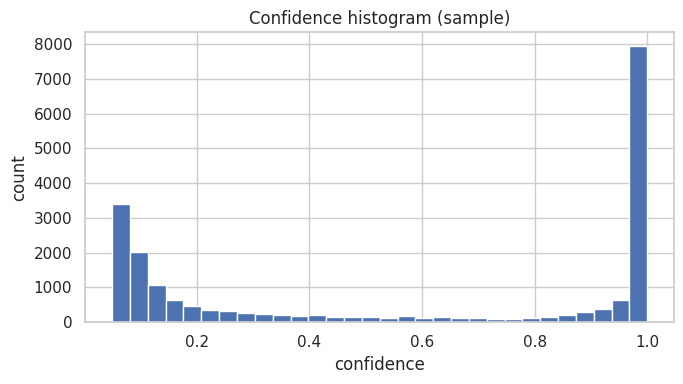

In [36]:
plt.figure(figsize=(7,4))
plt.hist(conf_sample, bins=30)
plt.title("Confidence histogram (sample)")
plt.xlabel("confidence")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "Hist_Confidence_Kosmas_Katsioulas_ME2109.png"))
plt.show()

In [37]:
pct_tiny = float(((wh_sample[:,0] < 8) | (wh_sample[:,1] < 8)).mean()*100) if len(wh_sample) else 0.0
print(f"% Tiny bbox (<8 px): {pct_tiny:.2f}%")

% Tiny bbox (<8 px): 0.19%


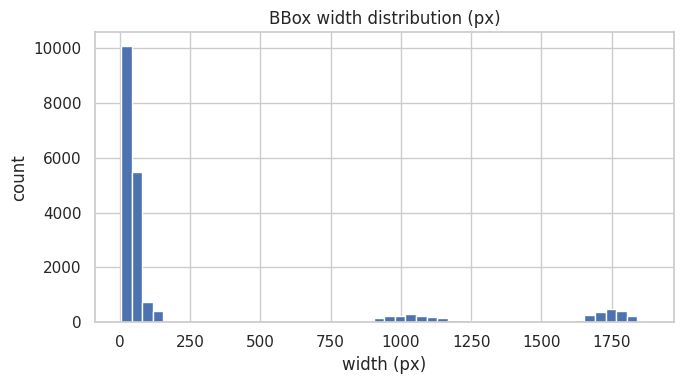

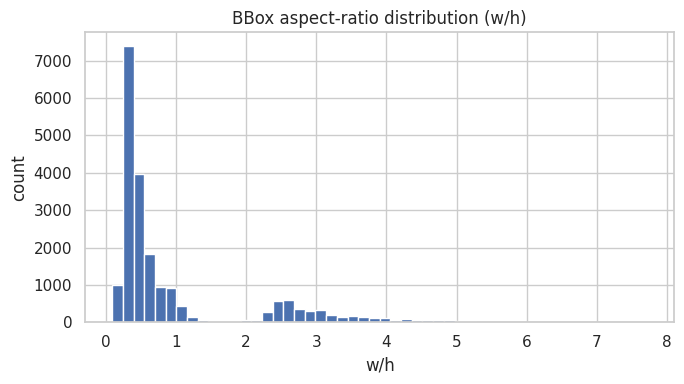

{'aspect_mean': 0.9628316760194818, 'aspect_p10': 0.2805991567433527, 'aspect_p90': 2.7705360671531825}


In [38]:
if len(wh_sample):
    w_vals = wh_sample[:,0]; h_vals = wh_sample[:,1]
    aspect = w_vals / np.maximum(h_vals, 1e-6)
    aspect = aspect[np.isfinite(aspect)]

    plt.figure(figsize=(7,4))
    plt.hist(w_vals, bins=50)
    plt.title("BBox width distribution (px)")
    plt.xlabel("width (px)"); plt.ylabel("count")
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "Hist_bbox_Width_Kosmas_Katsioulas_ME2109.png"))
    plt.show()

    plt.figure(figsize=(7,4))
    plt.hist(aspect, bins=50)
    plt.title("BBox aspect-ratio distribution (w/h)")
    plt.xlabel("w/h"); plt.ylabel("count")
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "Hist_bbox_Aspect_Kosmas_Katsioulas_ME2109.png"))
    plt.show()

    print({
        "aspect_mean": float(aspect.mean()),
        "aspect_p10": float(np.percentile(aspect, 10)),
        "aspect_p90": float(np.percentile(aspect, 90)),
    })

# **Ground Truth Boxes Preview**

In [39]:
def montage_with_boxes(csv_candidates: list, picks: int = 8, conf_thr: float = 0.2):

    chosen = []

    for cp in csv_candidates:

        df = parse_uniri_csv(cp)

        if df.empty:
            continue

        fmin, fmax = int(df.frame.min()), int(df.frame.max())
        f = random.randint(fmin, fmax)
        chosen.append((cp, f))

        if len(chosen) >= picks:
            break

    images_rgb = []
    for cp, f in chosen:

        vid = video_path_from_csv(cp)
        cap = cv2.VideoCapture(vid)
        cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, f-1))
        ok, frm = cap.read()
        cap.release()

        if not ok or frm is None:

            continue

        df = parse_uniri_csv(cp)
        sub = df[(df.frame == f) & (df.conf >= conf_thr)]
        boxes = sub[["x1","y1","x2","y2"]].to_numpy()
        vis = overlay_boxes_on_image(frm, boxes)
        images_rgb.append(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))

    if not images_rgb:
        print("No samples found for montage.")
        return

    cols = 4
    rows = math.ceil(len(images_rgb)/cols)
    plt.figure(figsize=(16, 4*rows))

    for i, im in enumerate(images_rgb, start=1):

        plt.subplot(rows, cols, i)
        plt.imshow(im); plt.axis("off")

    plt.suptitle("Montage Preview with GT Boxes")
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "Montage_Ground_Truth_Boxes_Kosmas_Katsioulas_ME2109.png"))
    plt.show()

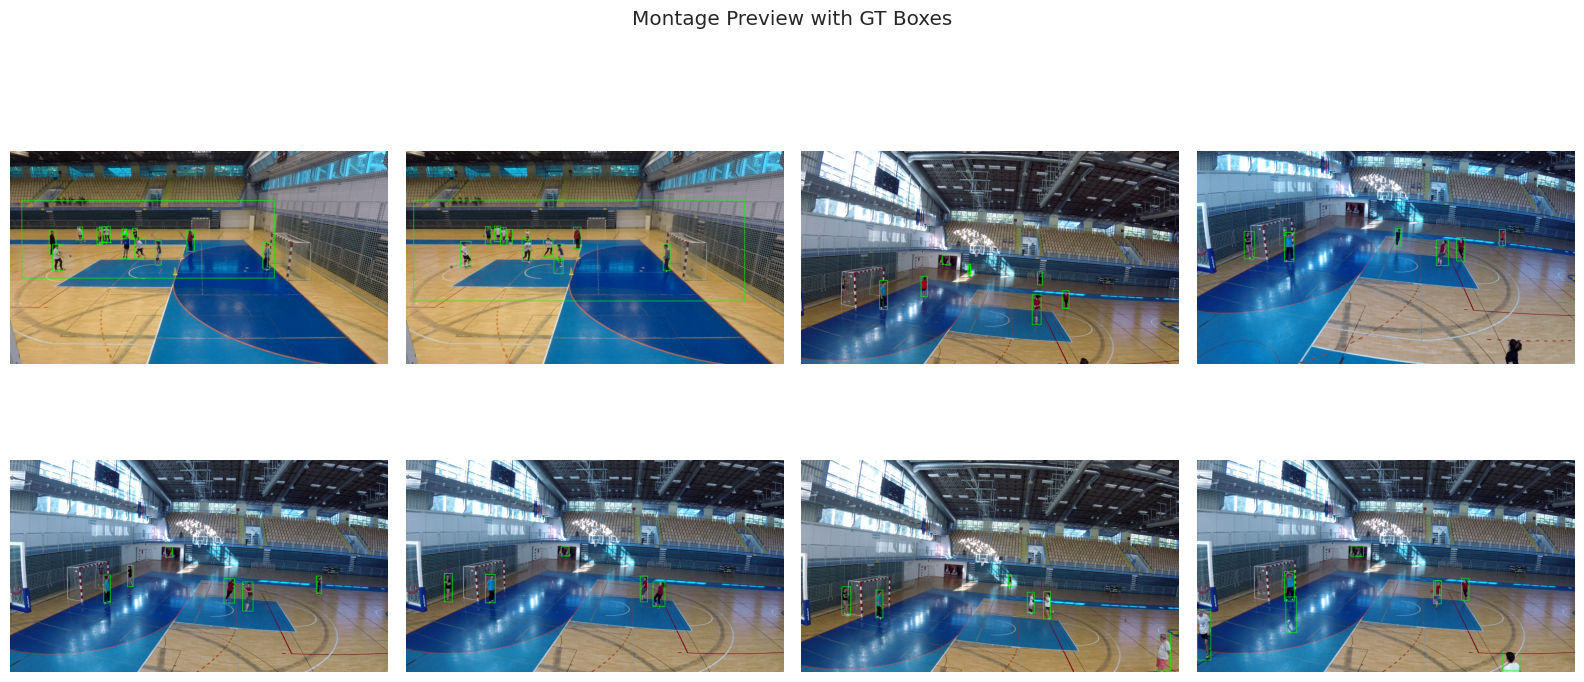

In [40]:
some_csvs = sorted(all_csvs)[:40]
montage_with_boxes(some_csvs, picks=8, conf_thr=0.20)

# **Class Balance & Frames/Clip Aprroach**

In [41]:
rows = []

for a in actions:

    csvs = sorted(glob.glob(os.path.join(detections_dir, a, "*.csv")))
    vids = sorted(glob.glob(os.path.join(scenes_dir, a, "*.mp4")))
    approx_frames = 0

    for cp in csvs[:5]:

        d = parse_uniri_csv(cp)
        approx_frames += int(d["frame"].nunique()) if not d.empty else 0

    rows.append({"action": a, "csv_count": len(csvs), "video_count": len(vids), "approx_frames_in_5_csv": approx_frames})

In [42]:
df_balance = pd.DataFrame(rows).sort_values("csv_count", ascending=False)
display(df_balance)

,action,csv_count,video_count,approx_frames_in_5_csv
3,jump-shot,367,370,360
0,crossing,129,129,393
4,passing,104,104,358
6,shot,102,102,391
2,dribbling,24,24,393
1,defence,16,16,504
5,running,9,9,521


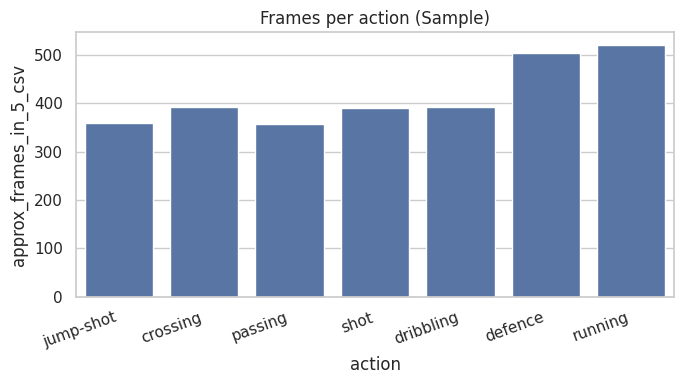

In [43]:
plt.figure(figsize=(7,4))
sns.barplot(df_balance, x="action", y="approx_frames_in_5_csv")
plt.title("Frames per action (Sample)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "Approx_Frames_Balance_Kosmas_Katsioulas_ME2109.png"))
plt.show()

# **Data Integrity Check**

In [44]:
def sanity_on_csv(cp: str, cap_rows: int = 20000) -> dict:

    df = parse_uniri_csv(cp)

    if df.empty:

        return {"bad_size": 0, "out_of_bounds": 0, "nan_or_inf": 0, "neg_conf": 0}

    vp = video_path_from_csv(cp)
    cap = cv2.VideoCapture(vp)
    ok, frame0 = cap.read()
    cap.release()

    if not ok or frame0 is None:

        return {"bad_size": 0, "out_of_bounds": 0, "nan_or_inf": 0, "neg_conf": 0}

    H, W = frame0.shape[:2]
    d = df if len(df) <= cap_rows else df.sample(cap_rows, random_state=SEED)

    w = (d.x2 - d.x1); h = (d.y2 - d.y1)
    bad_size = int(((w <= 1) | (h <= 1)).sum())
    oob = int(((d.x1 < 0) | (d.y1 < 0) | (d.x2 > W) | (d.y2 > H)).sum())
    nan_inf = int((~np.isfinite(d[["x1","y1","x2","y2","conf"]]).all(axis=1)).sum())
    neg_conf = int((d["conf"] < 0).sum())

    return {"bad_size": bad_size, "out_of_bounds": oob, "nan_or_inf": nan_inf, "neg_conf": neg_conf}

In [45]:
summary_rows = []

for a in actions:

    csvs = sorted(glob.glob(os.path.join(detections_dir, a, "*.csv")))[:10]
    agg = defaultdict(int)

    for cp in csvs:

        s = sanity_on_csv(cp)

        for k,v in s.items():
            agg[k] += int(v)

    summary_rows.append({"action": a, **agg})

In [46]:
df_sanity = pd.DataFrame(summary_rows).sort_values("action")
display(df_sanity)

,action,bad_size,out_of_bounds,nan_or_inf,neg_conf
0,crossing,0,0,0,0
1,defence,0,0,0,0
2,dribbling,0,0,0,0
3,jump-shot,0,0,0,0
4,passing,0,0,0,0
5,running,0,0,0,0
6,shot,0,0,0,0


# **Stats per Clip & per Action**

In [47]:
df_sanity.to_csv(os.path.join(results_dir, "Sanity_Checks_per_Action_Kosmas_Katsioulas_ME2109.csv"), index=False)

In [48]:
def build_clip_level_summary(csv_path: str) -> dict:

    action = os.path.basename(os.path.dirname(csv_path))
    stem = Path(csv_path).stem
    d = parse_uniri_csv(csv_path)

    if d.empty:

        return {"action": action, "clip": stem, "csv_path": csv_path, "n_rows": 0, "n_frames": 0, "min_frame": np.nan, "max_frame": np.nan, "frames_with_dets": 0, "mean_dets_per_frame": 0.0, "missing_frames": 0, "mean_w": 0.0, "mean_h": 0.0, "mean_ar": 0.0, "mean_area": 0.0, "conf_median": 0.0, "conf_p10": 0.0, "conf_p90": 0.0}

    d["w"] = (d.x2 - d.x1).clip(lower=0)
    d["h"] = (d.y2 - d.y1).clip(lower=0)
    d = d[(d.w > 1) & (d.h > 1)]

    if d.empty:
        return {"action": action, "clip": stem, "csv_path": csv_path, "n_rows": 0, "n_frames": 0, "min_frame": np.nan, "max_frame": np.nan, "frames_with_dets": 0, "mean_dets_per_frame": 0.0, "missing_frames": 0, "mean_w": 0.0,"mean_h": 0.0, "mean_ar": 0.0, "mean_area": 0.0, "conf_median": 0.0, "conf_p10": 0.0, "conf_p90": 0.0}

    d["ar"] = d.w / d.h
    d["area"] = d.w * d.h

    frames = sorted(d.frame.unique().tolist())
    minf, maxf = int(min(frames)), int(max(frames))
    n_frames = len(frames)
    missing = 0

    if n_frames > 1:
        expected = set(range(minf, maxf + 1))
        missing = len(expected.difference(frames))

    per_frame_counts = d.groupby("frame").size()

    return {
        "action": action, "clip": stem, "csv_path": csv_path,
        "n_rows": int(len(d)),
        "n_frames": int(n_frames),
        "min_frame": minf, "max_frame": maxf,
        "frames_with_dets": int((per_frame_counts > 0).sum()) if not per_frame_counts.empty else 0,
        "mean_dets_per_frame": float(per_frame_counts.mean()) if not per_frame_counts.empty else 0.0,
        "missing_frames": int(missing),
        "mean_w": float(d.w.mean()), "mean_h": float(d.h.mean()),
        "mean_ar": float(d.ar.mean()), "mean_area": float(d.area.mean()),
        "conf_median": float(d.conf.median()),
        "conf_p10": float(d.conf.quantile(0.10)),
        "conf_p90": float(d.conf.quantile(0.90)),
    }

In [49]:
clip_rows = []
for a in actions:
    for cp in sorted(glob.glob(os.path.join(detections_dir, a, "*.csv"))):
        clip_rows.append(build_clip_level_summary(cp))

In [50]:
df_per_clip = pd.DataFrame(clip_rows).sort_values(["action","clip"]).reset_index(drop=True)
df_per_clip.to_csv(os.path.join(results_dir, "Summary_per_Clip_Kosmas_Katsioulas_ME2109.csv"), index=False)
display(df_per_clip.head())

,action,clip,csv_path,n_rows,n_frames,min_frame,max_frame,frames_with_dets,mean_dets_per_frame,missing_frames,mean_w,mean_h,mean_ar,mean_area,conf_median,conf_p10,conf_p90
0,crossing,crossing_KS_1,/content/uniri-hbd/handball_s/player_detection...,1747,82,1,82,82,21.304878,0,311.265400,164.369051,1.098358,127610.790630,0.710556,0.073535,0.993532
1,crossing,crossing_KS_10,/content/uniri-hbd/handball_s/player_detection...,1480,81,1,81,81,18.271605,0,315.265038,167.509717,1.097841,131596.595864,0.841927,0.076476,0.994370
2,crossing,crossing_KS_100,/content/uniri-hbd/handball_s/player_detection...,919,67,1,67,67,13.716418,0,219.620627,122.669896,0.868544,75058.913740,0.398354,0.063750,0.995823
3,crossing,crossing_KS_101,/content/uniri-hbd/handball_s/player_detection...,1044,81,1,81,81,12.888889,0,229.877477,161.254448,0.738226,119202.289894,0.713896,0.065702,0.997416
4,crossing,crossing_KS_102,/content/uniri-hbd/handball_s/player_detection...,993,82,1,82,82,12.109756,0,329.758004,174.651949,1.018533,158942.006073,0.252524,0.065138,0.996796


In [51]:
df_per_action = df_per_clip.groupby("action").agg(
    clips=("clip","nunique"),
    total_boxes=("n_rows","sum"),
    mean_frames=("n_frames","mean"),
    mean_dets_per_fr=("mean_dets_per_frame","mean"),
    mean_missing=("missing_frames","mean"),
    mean_w=("mean_w","mean"),
    mean_h=("mean_h","mean"),
    mean_ar=("mean_ar","mean"),
    mean_area=("mean_area","mean"),
    conf_med=("conf_median","mean"),
    conf_p10=("conf_p10","mean"),
    conf_p90=("conf_p90","mean"),
).reset_index()

In [52]:
df_per_action.to_csv(os.path.join(results_dir, "Summary_per_Action_Kosmas_Katsioulas_ME2109.csv"), index=False)
display(df_per_action)

,action,clips,total_boxes,mean_frames,mean_dets_per_fr,mean_missing,mean_w,mean_h,mean_ar,mean_area,conf_med,conf_p10,conf_p90
0,crossing,129,151627,78.069767,14.985309,0.0,278.240417,177.168891,0.914350,128244.911887,0.801829,0.069442,0.996840
1,defence,16,18333,90.625000,12.814180,0.0,232.995005,181.599774,0.743586,113200.618072,0.804551,0.069782,0.997812
2,dribbling,24,44706,86.750000,21.445786,0.0,183.123744,111.263125,0.832308,70868.480986,0.421887,0.066168,0.986891
3,jump-shot,367,899270,79.607629,30.140707,0.0,207.127568,133.557444,0.882513,85720.881261,0.428619,0.067344,0.989738
4,passing,104,176891,70.576923,24.179183,0.0,207.829058,115.752747,0.985421,68513.685832,0.593470,0.069298,0.989959
5,running,9,31804,117.666667,29.769850,0.0,169.263533,105.522854,0.708300,81121.142553,0.423158,0.068705,0.983194
6,shot,102,289163,82.578431,34.632751,0.0,220.016667,144.739247,0.883416,90542.911510,0.533957,0.072415,0.991182


# **CSV correspondence with MP4**

In [53]:
mapping_rows = []
dup_rows = []
coverage_rows = []

for csv_path in df_per_clip["csv_path"]:

    video_path = video_path_from_csv(csv_path)
    video_exists = os.path.exists(video_path)

    d = parse_uniri_csv(csv_path)
    dup_count = 0

    if not d.empty:

        cnt = Counter(d["frame"].tolist())
        dup_count = sum(1 for _, v in cnt.items() if v > 1)

    unique_label_frames = int(d["frame"].nunique()) if not d.empty else 0
    video_frames = None

    if video_exists:

        cap = cv2.VideoCapture(video_path)
        video_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
        cap.release()

    coverage_ratio = (unique_label_frames / video_frames) if (video_frames and video_frames > 0) else np.nan

    mapping_rows.append({
        "csv_path": csv_path,
        "video_exists": video_exists,
        "video_frames": video_frames
    })

    dup_rows.append({"csv_path": csv_path, "duplicate_frames": dup_count})

    coverage_rows.append({
        "csv_path": csv_path,
        "unique_label_frames": unique_label_frames,
        "video_frames": video_frames,
        "coverage_ratio": coverage_ratio
    })

In [54]:
df_map = pd.DataFrame(mapping_rows)
df_dups = pd.DataFrame(dup_rows).sort_values("duplicate_frames", ascending=False)
df_cov  = pd.DataFrame(coverage_rows).sort_values("coverage_ratio", ascending=True)

In [55]:
print("CSV without corresponding video:", int((~df_map["video_exists"]).sum()))

CSV without corresponding video: 0


In [56]:
display(df_map.head())

,csv_path,video_exists,video_frames
0,/content/uniri-hbd/handball_s/player_detection...,True,82
1,/content/uniri-hbd/handball_s/player_detection...,True,81
2,/content/uniri-hbd/handball_s/player_detection...,True,67
3,/content/uniri-hbd/handball_s/player_detection...,True,81
4,/content/uniri-hbd/handball_s/player_detection...,True,82


In [57]:
display(df_dups.head())

,csv_path,duplicate_frames
648,/content/uniri-hbd/handball_s/player_detection...,146
246,/content/uniri-hbd/handball_s/player_detection...,145
647,/content/uniri-hbd/handball_s/player_detection...,145
81,/content/uniri-hbd/handball_s/player_detection...,145
297,/content/uniri-hbd/handball_s/player_detection...,135


In [58]:
display(df_cov.head())

,csv_path,unique_label_frames,video_frames,coverage_ratio
735,/content/uniri-hbd/handball_s/player_detection...,81,81,1.0
734,/content/uniri-hbd/handball_s/player_detection...,81,81,1.0
733,/content/uniri-hbd/handball_s/player_detection...,81,81,1.0
732,/content/uniri-hbd/handball_s/player_detection...,82,82,1.0
731,/content/uniri-hbd/handball_s/player_detection...,97,97,1.0


# **Outliers per Action**

In [59]:
def outlier_stats_for_action(action_name: str) -> dict:

    csvs = sorted(glob.glob(os.path.join(detections_dir, action_name, "*.csv")))

    chunks = []

    for cp in csvs:

        df = parse_uniri_csv(cp)

        if df.empty:

            continue

        w = (df.x2 - df.x1).clip(lower=0)
        h = (df.y2 - df.y1).clip(lower=0)
        chunks.append(pd.DataFrame({"w": w, "h": h}))

    if not chunks:

        return {"tiny_%": 0.0, "huge_%": 0.0, "median_w": 0.0, "median_h": 0.0}

    Z = pd.concat(chunks, ignore_index=True)
    tiny = ((Z["w"] < 8) | (Z["h"] < 8)).mean() * 100.0
    huge = ((Z["w"] > 500) | (Z["h"] > 500)).mean() * 100.0

    return {
        "tiny_%": float(tiny),
        "huge_%": float(huge),
        "median_w": float(Z["w"].median()),
        "median_h": float(Z["h"].median())
    }

In [60]:
outlier_rows = []
for a in actions:
    outlier_rows.append({"action": a, **outlier_stats_for_action(a)})

In [61]:
df_outliers = pd.DataFrame(outlier_rows).sort_values("tiny_%", ascending=False)
display(df_outliers)

,action,tiny_%,huge_%,median_w,median_h
2,dribbling,2.245784,12.640361,24.20200,66.8895
4,passing,1.928871,12.834457,30.74000,83.7920
5,running,1.358320,10.253427,18.78175,54.1840
3,jump-shot,1.210093,12.798159,27.77800,77.2170
1,defence,0.463645,14.367534,54.25000,135.7260
0,crossing,0.273038,18.913518,46.03000,123.6960
6,shot,0.265594,16.101645,33.04050,92.6750


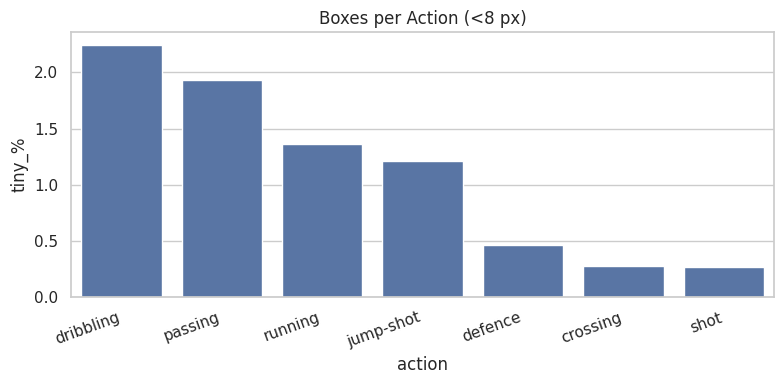

In [62]:
plt.figure(figsize=(8,4))
sns.barplot(df_outliers, x="action", y="tiny_%")
plt.title("Boxes per Action (<8 px)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "Outliers_Tiny_per_Action_Kosmas_Katsioulas_ME2109.png"))
plt.show()

# **Frames per Clip per Action**

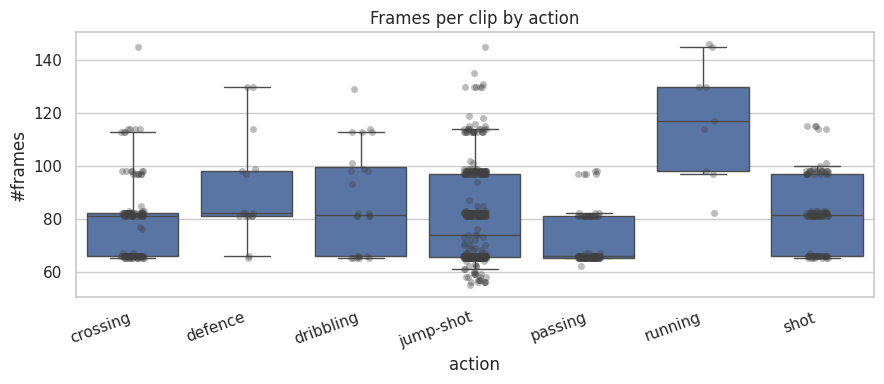

In [64]:
plt.figure(figsize=(9,4))
sns.boxplot(df_per_clip, x="action", y="n_frames", whis=[5,95], showfliers=False)
sns.stripplot(df_per_clip, x="action", y="n_frames", color="0.25", alpha=0.35)
plt.title("Frames per clip by action")
plt.xlabel("action"); plt.ylabel("#frames")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "Frames_per_Clip_by_Action_BoxStrip_Kosmas_Katsioulas_ME2109.png"))
plt.show()

# **Frequency of Player Detections per Action**

In [65]:
class_counts = df_per_clip.groupby("action")["n_rows"].sum().rename("player_boxes").reset_index()
display(class_counts)

,action,player_boxes
0,crossing,151627
1,defence,18333
2,dribbling,44706
3,jump-shot,899270
4,passing,176891
5,running,31804
6,shot,289163


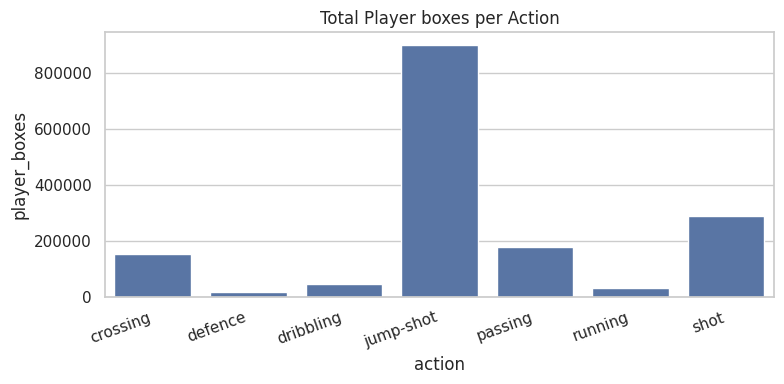

In [67]:
plt.figure(figsize=(8,4))
sns.barplot(class_counts, x="action", y="player_boxes")
plt.title("Total Player boxes per Action")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "Bar_Player_boxes_per_Action_Kosmas_Katsioulas_ME2109.png"))
plt.show()

In [68]:
class_counts.to_csv(os.path.join(results_dir, "Class_counts_per_Action_Kosmas_Katsioulas_ME2109.csv"), index=False)

**Check Missing Frames**

# **Checking Missing Frames**

In [69]:
missing_report = df_per_clip[df_per_clip["missing_frames"] > 0].copy()
display(missing_report.head(10))

,action,clip,csv_path,n_rows,n_frames,min_frame,max_frame,frames_with_dets,mean_dets_per_frame,missing_frames,mean_w,mean_h,mean_ar,mean_area,conf_median,conf_p10,conf_p90


In [70]:
missing_report.to_csv(os.path.join(results_dir, "Missing_Frames_Report_Kosmas_Katsioulas_ME2109.csv"), index=False)

# **Histogram of Frames per Clip**

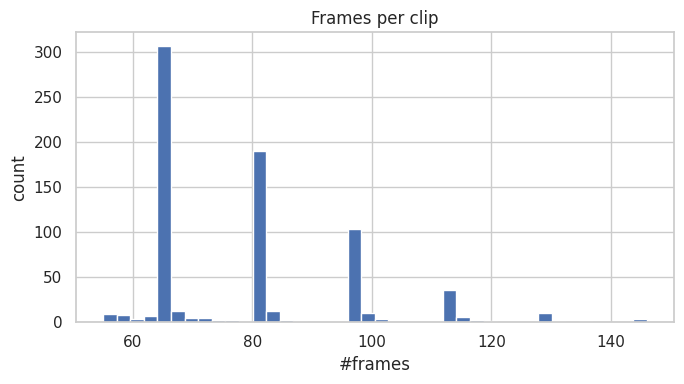

In [71]:
frames_len = df_per_clip["n_frames"].dropna().astype(int).values
if len(frames_len):
    plt.figure(figsize=(7,4))
    plt.hist(frames_len, bins=40)
    plt.title("Frames per clip")
    plt.xlabel("#frames"); plt.ylabel("count")
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "Hist_frames_per_Clip_Kosmas_Katsioulas_ME2109.png"))
    plt.show()

# **Executive Summary**

In [72]:
total_csv = int(df_per_clip.shape[0])
total_boxes = int(df_per_clip["n_rows"].sum())
actions_list = ", ".join(sorted(df_per_clip["action"].unique()))

In [73]:
print("===== EDA Executive Summary =====")
print(f"Total CSV: {total_csv}")
print(f"Total boxes: {total_boxes:,}")
print(f"Actions: {actions_list}")

===== EDA Executive Summary =====
Total CSV: 751
Total boxes: 1,611,794
Actions: crossing, defence, dribbling, jump-shot, passing, running, shot
